Training and testing with stat-consult sensor measurements (IMU-ECG-Pressure)

In [1]:
# Importing libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from keras import layers
import tensorflow as tf
import keras 
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.signal import butter, filtfilt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# File folder_location for the dataset
folder_path ='C:/Users/val-c/Desktop/synchronised_measurements' 
# Get the list of all files in the folder_location
file_list = os.listdir(folder_path)
# Loop via the list of files & read them into pd
dataframes = []
for file_name in file_list:
    if file_name.endswith(".xlsx"):  # respective activity files in excel format
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        dataframes.append(df)
# Combine all the files into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.head(n=8)  # display selected nos of rows

,g0X_LSM6DSL,g0Y_LSM6DSL,g0Z_LSM6DSL,a0X_LSM6DSL,a0Y_LSM6DSL,a0Z_LSM6DSL,m0X_LSM303AH,m0Y_LSM303AH,m0Z_LSM303AH,ECG-Data,Pres,classes
0,0.008750,-0.008750,-0.078750,-1.006500,0.000000,0.023180,-0.0420,-0.678000,-0.796500,4208173,995.314941,1
1,0.009872,-0.016603,-0.079872,-1.007032,-0.000688,0.021241,-0.0445,-0.679538,-0.797846,4208183,995.314950,1
2,0.010994,-0.024455,-0.080994,-1.007564,-0.001376,0.019301,-0.0470,-0.681077,-0.799192,4208171,995.314959,1
3,0.012115,-0.032308,-0.082115,-1.008095,-0.002065,0.017362,-0.0495,-0.682615,-0.800538,4208169,995.314968,1
4,0.013237,-0.040160,-0.083237,-1.008627,-0.002753,0.015422,-0.0520,-0.684154,-0.801885,4208218,995.314976,1
5,0.014359,-0.048013,-0.084359,-1.009159,-0.003441,0.013483,-0.0545,-0.685692,-0.803231,4208241,995.314985,1
6,0.015481,-0.055865,-0.085481,-1.009691,-0.004129,0.011543,-0.0570,-0.687231,-0.804577,4208228,995.314994,1
7,0.016603,-0.063718,-0.086603,-1.010223,-0.004817,0.009604,-0.0595,-0.688769,-0.805923,4208203,995.315003,1


In [3]:
#Save the single_dataframe to a csv-file >> (built_homogenous_dataset)
#combined_df.to_csv('built_homogenous_dataset.csv', index=False)

In [4]:
# Display info of the dataframe
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123045 entries, 0 to 123044
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   g0X_LSM6DSL   123045 non-null  float64
 1   g0Y_LSM6DSL   123045 non-null  float64
 2   g0Z_LSM6DSL   123045 non-null  float64
 3   a0X_LSM6DSL   123045 non-null  float64
 4   a0Y_LSM6DSL   123045 non-null  float64
 5   a0Z_LSM6DSL   123045 non-null  float64
 6   m0X_LSM303AH  123045 non-null  float64
 7   m0Y_LSM303AH  123045 non-null  float64
 8   m0Z_LSM303AH  123045 non-null  float64
 9   ECG-Data      123045 non-null  int64  
 10  Pres          123045 non-null  float64
 11  classes       123045 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 11.3 MB


In [5]:
# Convert "ECG-Data" column from integer to float  
combined_df["ECG-Data"] = combined_df["ECG-Data"].astype(float)

In [6]:
# Class labels in the dataframe (df)
unique_label = np.unique(combined_df.classes)
class_label = np.sort(unique_label)
print(class_label)

[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [7]:
# Checking for missing values in the df
combined_df.isna().sum(axis=0).to_frame('Total')

,Total
g0X_LSM6DSL,0
g0Y_LSM6DSL,0
g0Z_LSM6DSL,0
a0X_LSM6DSL,0
a0Y_LSM6DSL,0
a0Z_LSM6DSL,0
m0X_LSM303AH,0
m0Y_LSM303AH,0
m0Z_LSM303AH,0
ECG-Data,0


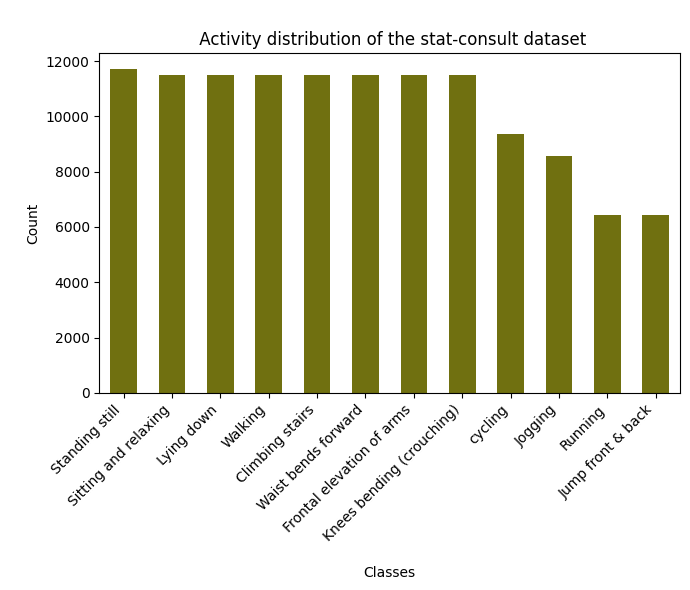

In [8]:
# Plot the number of samples present in each class_label
class_label = ['Standing still','Sitting and relaxing','Lying down','Walking', 'Climbing stairs',
               'Waist bends forward', 'Frontal elevation of arms','Knees bending (crouching)',
               'cycling','Jogging','Running','Jump front & back']
plt.figure(figsize=(7, 6)) # figure sizing 
num_of_classes = len(class_label)
# Creating barplot for the activitiy distribution in the df
sns.barplot(x=class_label, y=combined_df["classes"].value_counts(), color='olive', width=0.55)
# Replace the numerical x-axis ticks with class labels
plt.xticks(range(num_of_classes), class_label, rotation=45, ha='right')
# the x_axis & y_axis labels, title
plt.xlabel('\nClasses', fontsize=10)
plt.ylabel('\nCount', fontsize=10)
plt.title("\n Activity distribution of the stat-consult dataset", fontsize=12)
#display plot
plt.tight_layout()
plt.show()

- Visualizing the measured data

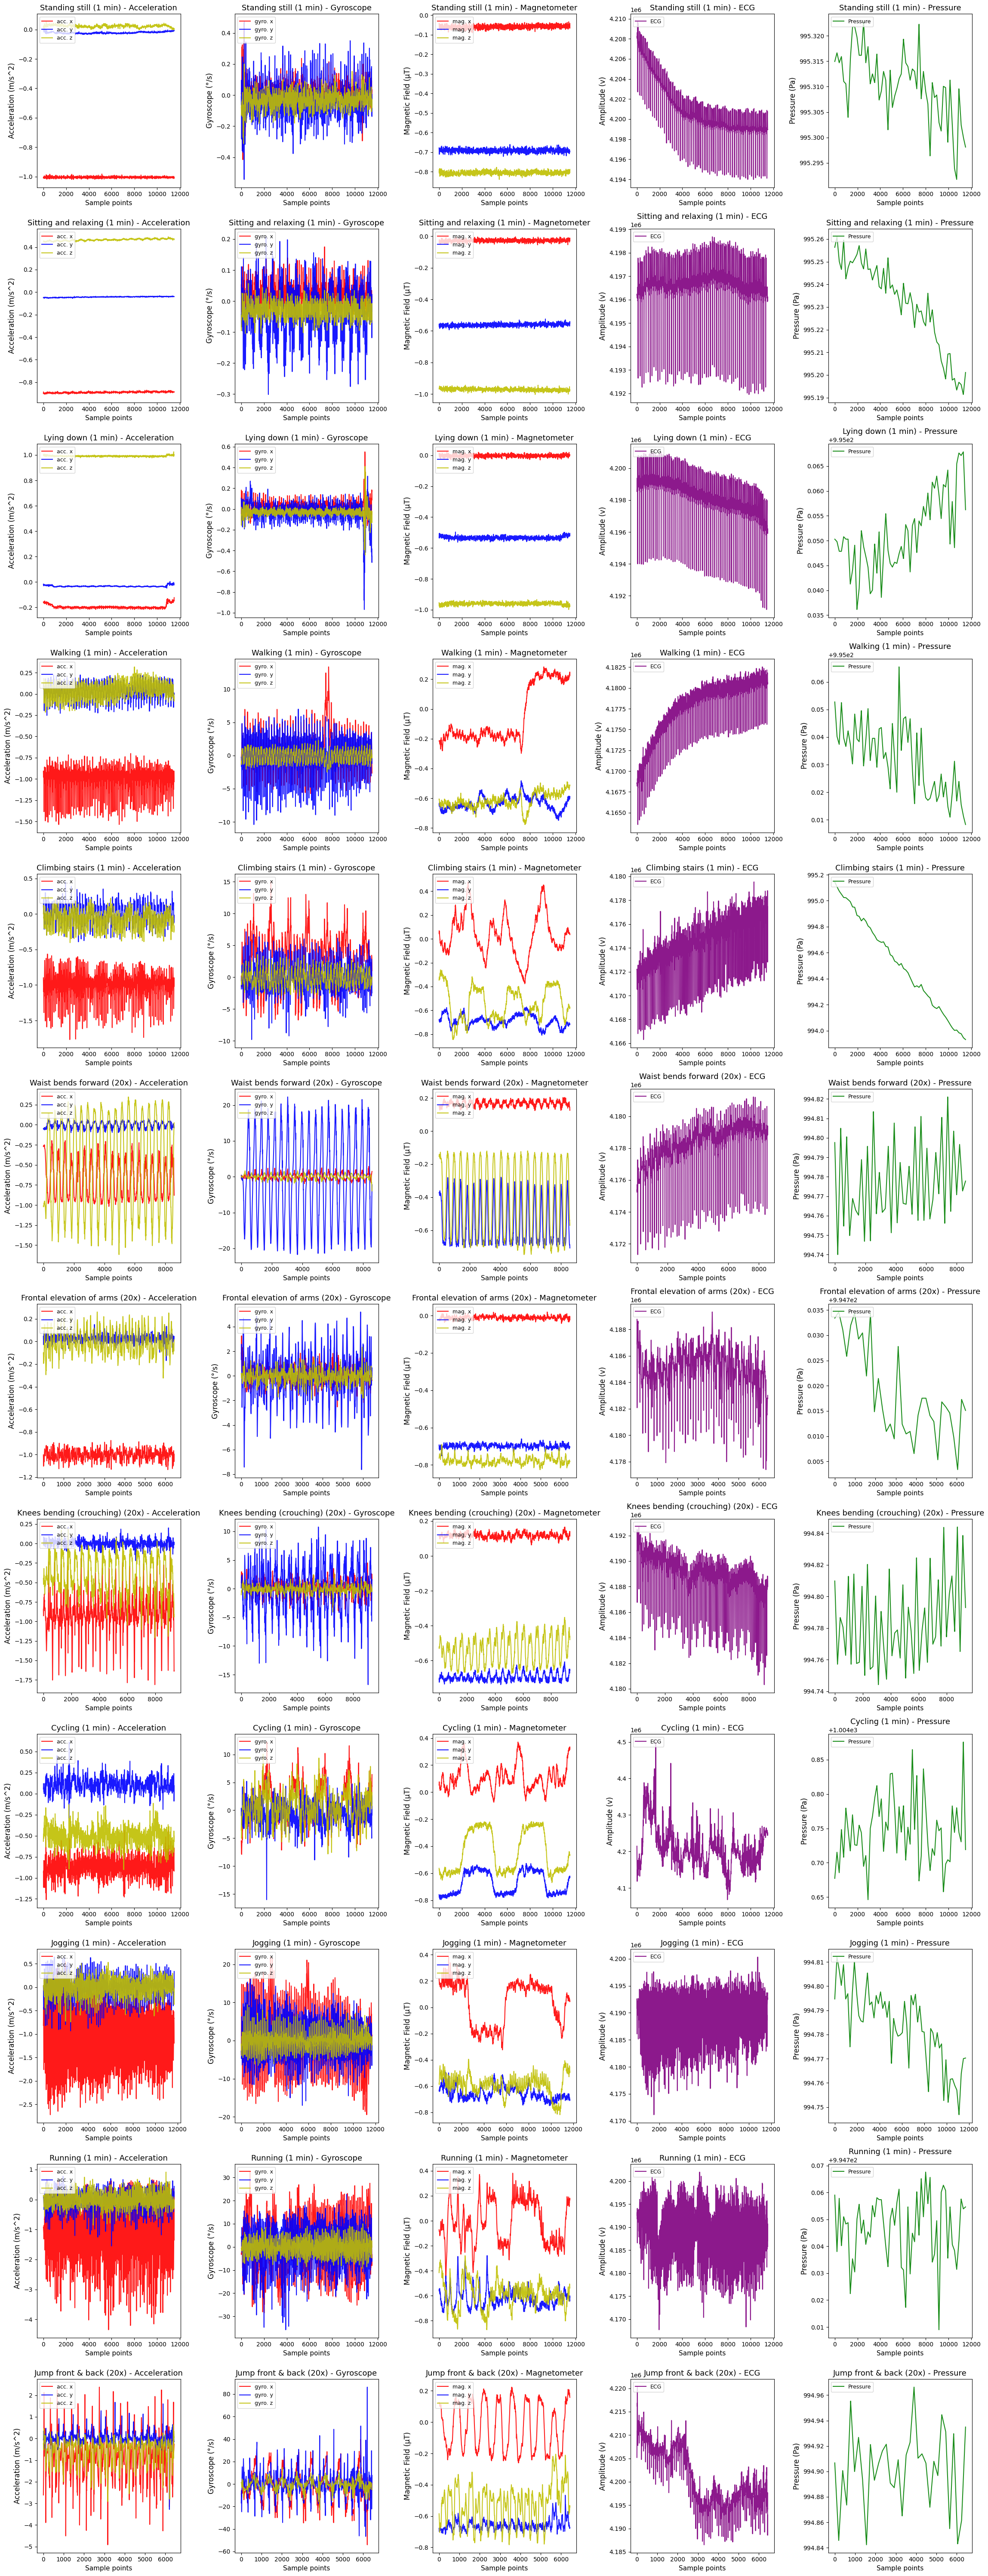

In [9]:
# Performed activities
activity_dict = {1: 'Standing still (1 min)',2: 'Sitting and relaxing (1 min)', 3: 'Lying down (1 min)', 4: 'Walking (1 min)',
    5: 'Climbing stairs (1 min)',6: 'Waist bends forward (20x)',7: 'Frontal elevation of arms (20x)',8: 'Knees bending (crouching) (20x)',
    9: 'Cycling (1 min)',10: 'Jogging (1 min)',11: 'Running (1 min)', 12: 'Jump front & back (20x)'}
# Determining the number of rows and columns for subplots
nos_row = len(activity_dict)
nos_col = 5  # (accelerometer, gyroscope, magnetometer, ECG, and pressure)
# Setting the subplots
fig, axs = plt.subplots(nos_row, nos_col, figsize=(23, 5 * nos_row)) #(dpi=90)
for i, activity_id in enumerate(activity_dict.keys()):
    # Plot accelerometer measurements for the performed activities
    axs[i, 0].plot(combined_df[combined_df['classes'] == activity_id].reset_index(drop=True)['a0X_LSM6DSL'], color='r', alpha=0.9)
    axs[i, 0].plot(combined_df[combined_df['classes'] == activity_id].reset_index(drop=True)['a0Y_LSM6DSL'], color='b', alpha=0.9)
    axs[i, 0].plot(combined_df[combined_df['classes'] == activity_id].reset_index(drop=True)['a0Z_LSM6DSL'], color='y', alpha=0.9)
    axs[i, 0].set_title(f'{activity_dict[activity_id]} - Acceleration', fontsize=13)
    axs[i, 0].set_ylabel('Acceleration (m/s^2)', fontsize=12)
    axs[i, 0].set_xlabel('Sample points', fontsize=11)
    axs[i, 0].legend(["acc. x", "acc. y", "acc. z"], fontsize=9, loc="upper left")
    # Plot gyroscope measurements for the performed activities
    axs[i, 1].plot(combined_df[combined_df['classes'] == activity_id].reset_index(drop=True)['g0X_LSM6DSL'], c='r', alpha=0.9)
    axs[i, 1].plot(combined_df[combined_df['classes'] == activity_id].reset_index(drop=True)['g0Y_LSM6DSL'], c='b', alpha=0.9)
    axs[i, 1].plot(combined_df[combined_df['classes'] == activity_id].reset_index(drop=True)['g0Z_LSM6DSL'], c='y', alpha=0.9)
    axs[i, 1].set_title(f'{activity_dict[activity_id]} - Gyroscope', fontsize=13)
    axs[i, 1].set_ylabel('Gyroscope (°/s)', fontsize=12)
    axs[i, 1].set_xlabel('Sample points', fontsize=11)
    axs[i, 1].legend(["gyro. x", "gyro. y", "gyro. z"], fontsize=9, loc="upper left")
    # Plot magnetometer measurements for the performed activities
    axs[i, 2].plot(combined_df[combined_df['classes'] == activity_id].reset_index(drop=True)['m0X_LSM303AH'], c='r', alpha=0.9)
    axs[i, 2].plot(combined_df[combined_df['classes'] == activity_id].reset_index(drop=True)['m0Y_LSM303AH'], c='b', alpha=0.9)
    axs[i, 2].plot(combined_df[combined_df['classes'] == activity_id].reset_index(drop=True)['m0Z_LSM303AH'], c='y', alpha=0.9)
    axs[i, 2].set_title(f'{activity_dict[activity_id]} - Magnetometer', fontsize=13)
    axs[i, 2].set_ylabel('Magnetic Field (μT)', fontsize=12)
    axs[i, 2].set_xlabel('Sample points', fontsize=11)
    axs[i, 2].legend(["mag. x", "mag. y", "mag. z"], fontsize=9, loc="upper left")
    # Plot ECG measurements for the performed activities
    axs[i, 3].plot(combined_df[combined_df['classes'] == activity_id].reset_index(drop=True)['ECG-Data'], c='purple', alpha=0.9)
    axs[i, 3].set_title(f'{activity_dict[activity_id]} - ECG', fontsize=13)
    axs[i, 3].set_ylabel('Amplitude (v)', fontsize=12)
    axs[i, 3].set_xlabel('Sample points', fontsize=11)
    axs[i, 3].legend(["ECG"], fontsize=9, loc="upper left")
    # Plot pressure measurements for the performed activities
    axs[i, 4].plot(combined_df[combined_df['classes'] == activity_id].reset_index(drop=True)['Pres'], c='g', alpha=0.9)
    axs[i, 4].set_title(f'{activity_dict[activity_id]} - Pressure', fontsize=13)
    axs[i, 4].set_ylabel('Pressure (Pa)', fontsize=12)
    axs[i, 4].set_xlabel('Sample points', fontsize=11)
    axs[i, 4].legend(["Pressure"], fontsize=9, loc="upper left")
# Adjust the layout
plt.tight_layout()
plt.show()# Display plots

In [10]:
# Features and class from the dataframe
Features =combined_df.copy() #features/input
Label = Features.pop('classes') # class/output/target

In [11]:
# Normalization of the features/input variables
scaler = StandardScaler()
normalized_feature = scaler.fit_transform(Features)

In [12]:
# Data-Segmentation
# Creating function for the sliding-window  
#num_time_step: specifies the length of each segment
#step_size: specifies the step size used to slide the window over the data
def create_sequences(X, y, num_time_step, stepsize=1): # X:input y: output/target
    segment, label = [],[]
    for i in range(0,len(X) - num_time_step, stepsize):
        x = X[i:(i + num_time_step)]
        labels = y[i: i + num_time_step]
        segment.append(x)
        label.append(stats.mode(labels)[0][0])
    return np.array(segment), np.array(label)

In [13]:
# Creating the data sequence 
X_seq, y_seq = create_sequences(normalized_feature, Label ,num_time_step=390, stepsize=195)
# print shape of the data
print(X_seq.shape, y_seq.shape)

(629, 390, 11) (629,)


In [14]:
# Extract window_length,number of features, number of outputs to be used in the input & ouput of the neural network
window_length,num_features,num_outputs= X_seq.shape[1], X_seq.shape[2],to_categorical(y_seq).shape[1]      
print(window_length,num_features,num_outputs)

390 11 13


In [15]:
# Perform cross-validation
scores = []
# Creating the k-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True) # K=(n_splits)=5 >> total nos of samples/total nos of samples * % to be used as test data 
for i, (train, test) in enumerate(kfold.split(X_seq, y_seq)):
    print(f'Fold {i}:')
    print(train.shape)
    print(test.shape)
    # Convert output variables to categorical (one-hot encoding)
    y_train_seq = to_categorical(y_seq[train])
    y_test_seq = to_categorical(y_seq[test])

    # Configuring the CNN-1D_LSTM network architecture
    input_shape = (window_length, num_features)
    model = keras.Sequential([
        # Input layer
        layers.Input(input_shape),
        layers.Conv1D(filters=64, kernel_size=3, padding='same'), # CNN-1D layer-1
        layers.BatchNormalization(), # batch_normalization
        layers.Activation('relu'), # activation function
        # Hidden Conv Layer
        layers.Conv1D(filters=64, kernel_size=3, padding='same'), # CNN-1D layer-2
        layers.BatchNormalization(), # batch_normalization
        layers.Activation('relu'), # activation function 
        # Recurrent LSTM Layers
        layers.LSTM(units=128, return_sequences=True), # LSTM layer-1
        layers.Activation('relu'), # activation function
        layers.LSTM(units=128, return_sequences=False), # LSTM layer-2
        layers.Activation('relu'), # activation function
        # Dense layers
        layers.Dense(128, activation="relu"),
        # Activation function for the output layer 'softmax' for Multi-classification
        layers.Dense(num_outputs, activation='softmax')])

    # Compiling the model
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10,
        decay_rate=0.9)
    opt = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)#optimizer
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])

    # Training the model
    model.fit(X_seq[train], y_train_seq , validation_data=(X_seq[test], y_test_seq), epochs=10, batch_size=64)

    # Predicting on the testing set
    y_pred = model.predict(X_seq[test])
    # Converting predictions to class_labels
    predctd_label = np.argmax(y_pred, axis=1)
    true_label = y_seq[test]

    # Calculate accuracy score for the current fold
    fold_accuracy = accuracy_score(true_label, predctd_label)
    # Storing the accuracy score for the fold
    scores.append(fold_accuracy)  
    
# Print the accuracy scores for each fold and finally compute the Mean accuracy
print('\n')
print(scores)
print('\n')
avg_acc = np.mean(scores)
print("Mean_Accuracy:", avg_acc)

Fold 0:
(503,)
(126,)
Epoch 1/10
8/8 [==============================] - 25s 2s/step - loss: 2.2848 - accuracy: 0.3161 - val_loss: 1.9967 - val_accuracy: 0.4921
Epoch 2/10
8/8 [==============================] - 16s 2s/step - loss: 1.4371 - accuracy: 0.6143 - val_loss: 1.3845 - val_accuracy: 0.7222
Epoch 3/10
8/8 [==============================] - 16s 2s/step - loss: 0.9231 - accuracy: 0.6700 - val_loss: 1.0720 - val_accuracy: 0.6746
Epoch 4/10
8/8 [==============================] - 17s 2s/step - loss: 0.6793 - accuracy: 0.7515 - val_loss: 0.8321 - val_accuracy: 0.7619
Epoch 5/10
8/8 [==============================] - 17s 2s/step - loss: 0.5301 - accuracy: 0.8290 - val_loss: 0.6809 - val_accuracy: 0.8095
Epoch 6/10
8/8 [==============================] - 21s 3s/step - loss: 0.4841 - accuracy: 0.8270 - val_loss: 0.5314 - val_accuracy: 0.8571
Epoch 7/10
8/8 [==============================] - 20s 3s/step - loss: 0.4055 - accuracy: 0.8787 - val_loss: 0.5633 - val_accuracy: 0.8651
Epoch 8/10
8

In [16]:
# Performance of the model on the testing set
# Calculating the mean accuracy in percentage (%)
avg_accuracy_percent=avg_acc * 100
# Print the mean accuracy
print(f"Mean_Accuracy: {avg_accuracy_percent:.1f} %")

Mean_Accuracy: 90.1 %


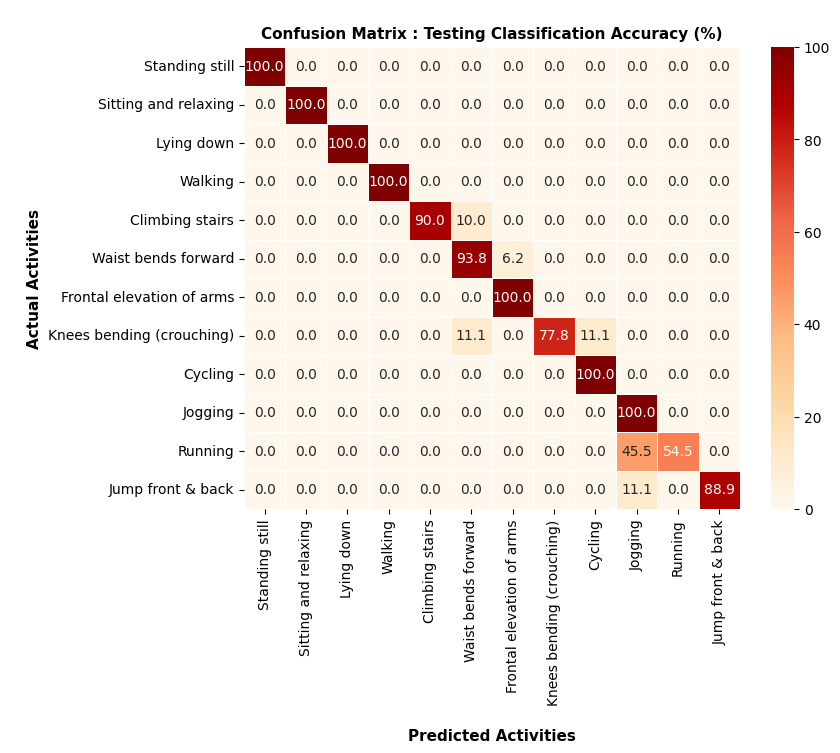

In [17]:
# Classes of the the performed activities
class_labels  = ['Standing still','Sitting and relaxing','Lying down','Walking','Climbing stairs',
                 'Waist bends forward', 'Frontal elevation of arms','Knees bending (crouching)','Cycling',
                 'Jogging','Running','Jump front & back']
# Create a confusion matrix >> test set
conf_matrix = confusion_matrix(np.argmax(y_test_seq, axis=1),predctd_label)
# Calculate accuracy percentages for each predicted activity labels
class_lbl_accuracy = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
# Plot the confusion matrix with accuracy percentages for the predictions
plt.figure(figsize=(8, 6))
sns.heatmap(class_lbl_accuracy, annot=True, fmt='.1f', cmap='OrRd', xticklabels=class_labels, yticklabels=class_labels, linewidths=0.5) #plot data
plt.title('\nConfusion Matrix : Testing Classification Accuracy (%)', fontsize=11, fontweight='bold')
plt.xlabel('\nPredicted Activities', fontsize=11, fontweight='bold')
plt.ylabel('\nActual Activities', fontsize=11, fontweight='bold')
plt.show() # display plot